<a href="https://colab.research.google.com/github/soumitrahazra/2DSPDy/blob/master/Different_CME_Property_Analysis_from_LASCO_image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#This is the code for the calculation of different CME properties (kinematical and morphological) from LASCO image.

This code is developed by Soumitra Hazra

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import glob
import cv2
from sunpy.net import Fido, attrs as a
from datetime import datetime, timedelta
import os
from bs4 import BeautifulSoup
import requests
import pandas as pd

In [57]:
# === Step 1: Create base output folder ===
base_dir = "/content/lasco_data"
os.makedirs(base_dir, exist_ok=True)

In [58]:
# === Set Time Range and Instrument ===
start_time = "2023-11-01 00:00"
end_time = "2023-11-01 3:00"  # adjust as needed

# Query for LASCO C2 images (change to C3 if needed)
result = Fido.search(
    a.Time(start_time, end_time),
    a.Instrument.lasco,
    a.Detector("C2"),  # or "C3"
    a.Physobs.intensity
)

# Print result summary
print(result)

Results from 1 Provider:

15 Results from the VSOClient:
Source: https://sdac.virtualsolar.org/cgi/search
Data retrieval status: https://docs.virtualsolar.org/wiki/VSOHealthReport
Total estimated size: 29.529 Mbyte

       Start Time               End Time        Source Instrument Provider  Physobs  Extent Type   Size 
                                                                                                  Mibyte
----------------------- ----------------------- ------ ---------- -------- --------- ----------- -------
2023-11-01 00:00:05.000 2023-11-01 00:00:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:12:05.000 2023-11-01 00:12:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:24:05.000 2023-11-01 00:24:30.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:36:07.000 2023-11-01 00:36:32.000   SOHO      LASCO     SDAC intensity      CORONA 2.01074
2023-11-01 00:48:05.000 2023-11-01 00:48:30.000  

In [59]:
def fetch_cme_events_from_txt(min_speed=500, min_width=60, start_date=None, end_date=None):
    # URL for the univ_all.txt catalog
    url = "https://cdaw.gsfc.nasa.gov/CME_list/UNIVERSAL/text_ver/univ_all.txt"

    # Download the catalog file
    response = requests.get(url)
    response.raise_for_status()  # Will raise an error if the download fails

    # Parse the file line-by-line
    lines = response.text.splitlines()

    # Filter the lines for relevant data (skip header lines)
    events = []
    for line in lines[10:]:  # Skipping header lines
        if len(line.strip()) == 0:
            continue  # Skip empty lines

        # Split by space (or multiple spaces) to capture columns
        cols = [col.strip() for col in line.split() if col.strip()]

        if len(cols) < 10:  # Skip malformed lines
            continue

        try:
            # Date and time extraction
            date_str = cols[0] + " " + cols[1]  # e.g., 2023/01/01 01:00:00
            event_time = datetime.strptime(date_str, "%Y/%m/%d %H:%M:%S")

            # Extract width, speed, and event data
            width = int(cols[6])
            speed = int(cols[7])

            if speed >= min_speed and width >= min_width:
                # If within speed and width limits, add to events
                if start_date and event_time < pd.to_datetime(start_date):
                    continue
                if end_date and event_time > pd.to_datetime(end_date):
                    continue

                events.append({
                    "time": event_time,
                    "width": width,
                    "speed": speed
                })
        except Exception as e:
            # Handle errors (e.g., value parsing errors)
            continue

    return events

In [60]:
# === Step 3: Download LASCO data ===
def download_lasco_images(events, instrument="C2", margin_min=60):
    # If a single event is passed, wrap it in a list
    if isinstance(events, dict):
        events = [events]
    elif isinstance(events, str):
        events = [{"time": datetime.strptime(events, "%Y-%m-%d %H:%M")}]

    for event in events:
        t0 = event["time"]
        t_start = (t0 - timedelta(minutes=30)).strftime("%Y-%m-%d %H:%M")
        t_end = (t0 + timedelta(minutes=margin_min)).strftime("%Y-%m-%d %H:%M")

        subdir = f"{t0.strftime('%Y-%m-%dT%H-%M')}_{instrument}"
        output_path = os.path.join(base_dir, subdir)
        os.makedirs(output_path, exist_ok=True)

        print(f"\n CME at {t0} | Speed: {event['speed']} km/s | Width: {event['width']}°")
        print(f"   Saving to: {output_path}")

        try:
            result = Fido.search(
                a.Time(t_start, t_end),
                a.Instrument.lasco,
                a.Detector(instrument),
                a.Physobs.intensity
            )

            if result.file_num > 0:
                files = Fido.fetch(result, path=os.path.join(output_path, "{file}"))
                print(f" Downloaded {len(files)} images.")
            else:
                print("⚠️ No data found.")
        except Exception as e:
            print(f"❌ Download error: {e}")


In [61]:
# Example usage
events = fetch_cme_events_from_txt(
    min_speed=600,
    min_width=100,
    start_date="2023-01-01",
    end_date="2023-03-31"
)


In [62]:
print(f"Found {len(events)} CME events.")
for event in events[:5]:
    print(event)

Found 186 CME events.
{'time': datetime.datetime(2023, 1, 2, 18, 36, 5), 'width': 734, 'speed': 1072}
{'time': datetime.datetime(2023, 1, 3, 6, 36, 5), 'width': 910, 'speed': 1051}
{'time': datetime.datetime(2023, 1, 3, 11, 36, 5), 'width': 348, 'speed': 649}
{'time': datetime.datetime(2023, 1, 3, 14, 12, 5), 'width': 712, 'speed': 703}
{'time': datetime.datetime(2023, 1, 4, 9, 12, 9), 'width': 486, 'speed': 824}


In [63]:
selected_cme_event=events[0]
print(selected_cme_event)

{'time': datetime.datetime(2023, 1, 2, 18, 36, 5), 'width': 734, 'speed': 1072}


In [64]:
download_lasco_images(selected_cme_event, instrument="C2", margin_min=60)


 CME at 2023-01-02 18:36:05 | Speed: 1072 km/s | Width: 734°
   Saving to: /content/lasco_data/2023-01-02T18-36_C2


Files Downloaded:   0%|          | 0/7 [00:00<?, ?file/s]

 Downloaded 7 images.


In [65]:
!pip install ffmpeg-python --quiet

In [66]:
import os
import glob
from astropy.io import fits
import matplotlib.pyplot as plt

fits_dir = "/content/lasco_data/2023-01-02T18-36_C2/"
output_img_dir = "/content/lasco_frames"
os.makedirs(output_img_dir, exist_ok=True)

fits_files = sorted(glob.glob(os.path.join(fits_dir, "*.fts")))

for i, file_path in enumerate(fits_files):
    with fits.open(file_path) as hdul:
        data = hdul[0].data

    # Optional: normalize for better contrast
    norm_data = (data - data.min()) / (data.max() - data.min())

    # Save frame as image
    frame_path = os.path.join(output_img_dir, f"frame_{i:03d}.jpg")
    plt.imsave(frame_path, norm_data, cmap='gray')


In [67]:
import ffmpeg

output_gif = "/content/cme_event.gif"

(
    ffmpeg
    .input('/content/lasco_frames/frame_%03d.jpg', framerate=1)
    .output(output_gif, vf='scale=800:-1', loop=0)
    .run(overwrite_output=True)
)

print(f"✅ GIF saved at {output_gif}")

✅ GIF saved at /content/cme_event.gif


CME Property Estimation via Ellipse Fitting

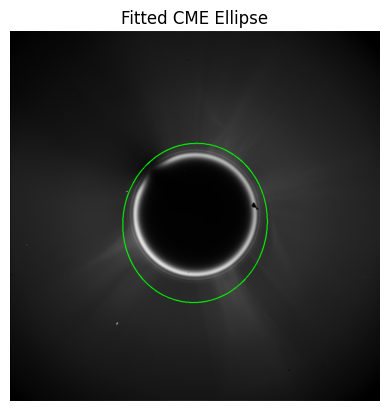

In [71]:
import cv2
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

# Load LASCO FITS image
fits_file = "/content/lasco_data/2023-01-02T18-36_C2/22888030.fts"
hdul = fits.open(fits_file)
data = hdul[0].data
header = hdul[0].header
hdul.close()

# Normalize and enhance contrast
norm = (data - np.min(data)) / (np.max(data) - np.min(data))
norm = (norm * 255).astype(np.uint8)

# Apply threshold to isolate CME front
_, thresh = cv2.threshold(norm, 60, 255, cv2.THRESH_BINARY)

# Find contours
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Select the largest contour (assumed to be CME front)
contour = max(contours, key=cv2.contourArea)

# Fit ellipse
ellipse = cv2.fitEllipse(contour)

# Draw results
result_img = cv2.cvtColor(norm, cv2.COLOR_GRAY2BGR)
cv2.ellipse(result_img, ellipse, (0, 255, 0), 2)

plt.imshow(result_img)
plt.title("Fitted CME Ellipse")
plt.axis('off')
plt.show()


In [72]:
# Sun center in image (approx; LASCO images are centered)
sun_center = (result_img.shape[1] // 2, result_img.shape[0] // 2)

# Ellipse center, axes, angle
(center_x, center_y), (major_axis, minor_axis), angle = ellipse

# Convert height (major axis) to km
pix_scale = header.get("CDELT1", 11.4)  # arcsec/pixel
rsun_arcsec = 959.63
rsun_km = 696340

height_arcsec = major_axis * pix_scale
height_rsun = height_arcsec / rsun_arcsec
height_km = height_rsun * rsun_km

# Angular width approximation (minor axis)
width_arcsec = minor_axis * pix_scale
width_deg = width_arcsec / 3600  # arcsec to degrees

# Position angle (ellipse orientation)
pa_deg = angle

print(f"🌞 Estimated CME Height: {height_rsun:.2f} Rsun ({height_km:.0f} km)")
print(f"🟠 Estimated Angular Width: {width_deg:.1f}°")
print(f"📐 Position Angle: {pa_deg:.1f}°")

🌞 Estimated CME Height: 4.96 Rsun (3452444 km)
🟠 Estimated Angular Width: 1.5°
📐 Position Angle: 6.2°


In [91]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from datetime import datetime
import glob
import re
import os

# Function to extract observation time from header or fallback to filename
def extract_observation_time(file_path, header):
    date_obs = header.get('DATE-OBS')
    time_obs = header.get('TIME-OBS')
    # Format date and time
    # Convert date from 'YYYY/MM/DD' to 'DD-MM-YYYY'
    formatted_date = datetime.strptime(date_obs, '%Y/%m/%d').strftime('%d-%m-%Y')
    # Remove milliseconds from time and convert to 'HH:MM:SS'
    formatted_time = time_obs.split('.')[0]

    if formatted_date and formatted_time:
        # Combine DATE_OBS and TIME_OBS to form a full datetime string
        full_time_str = f"{formatted_date} {formatted_time}"
        try:
            # Convert to datetime object
            return datetime.strptime(full_time_str, '%d-%m-%Y %H:%M:%S')
        except ValueError:
            print(f"❌ Invalid time format in file: {file_path}")
            return None

    # Fallback: extract from filename or path
    match = re.search(r'(\d{4})[-_/](\d{2})[-_/](\d{2})[T_]?(\d{2})[-_](\d{2})', file_path)
    if match:
        try:
            return datetime.strptime('-'.join(match.groups()), '%Y-%m-%d-%H-%M')
        except ValueError:
            pass
    return None

def process_cme_sequence(fits_dir, output_csv=None, show_plot=True):
    fits_files = sorted(glob.glob(f"{fits_dir}/**/*.fts", recursive=True))
    time_series = []
    height_series_rsun = []

    for file in fits_files:
        try:
            hdul = fits.open(file)
            data = hdul[0].data
            header = hdul[0].header
            hdul.close()

            t_obs = extract_observation_time(file, header)
            if t_obs is None:
                print(f"⏳ Skipped (no valid time): {file}")
                continue

            norm = (data - np.min(data)) / (np.max(data) - np.min(data))
            norm = (norm * 255).astype(np.uint8)
            _, thresh = cv2.threshold(norm, 60, 255, cv2.THRESH_BINARY)
            contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                continue

            contour = max(contours, key=cv2.contourArea)
            if len(contour) < 5:
                continue

            ellipse = cv2.fitEllipse(contour)
            (cx, cy), (major_axis, minor_axis), angle = ellipse
            img_center = (norm.shape[1] // 2, norm.shape[0] // 2)
            distance_px = np.linalg.norm(np.array([cx, cy]) - np.array(img_center))
            pix_scale = header.get("CDELT1", 11.4)  # Scale in arcseconds/pixel
            rsun_arcsec = 959.63  # Radius of the Sun in arcseconds
            distance_arcsec = distance_px * pix_scale
            height_rsun = distance_arcsec / rsun_arcsec

            time_series.append(t_obs)
            height_series_rsun.append(height_rsun)

        except Exception as e:
            print(f"❌ Error processing {file}: {e}")

    # Convert to DataFrame
    df = pd.DataFrame({
        "time": time_series,
        "height_rsun": height_series_rsun
    }).sort_values("time")

    # Plot with the full formatted time
    if show_plot and not df.empty:
        plt.figure(figsize=(8, 5))
        plt.plot(df["time"], df["height_rsun"], 'ro-')
        plt.title("CME Height vs Time")
        plt.xlabel("Time (DD-MM-YYYY HH:MM:SS)")
        plt.ylabel("Height (Rsun)")
        plt.xticks(rotation=45)

        # Format x-axis to show time in desired format
        plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%d-%m-%Y %H:%M:%S'))
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # Save to CSV
    if output_csv:
        df.to_csv(output_csv, index=False)
        print(f"✅ Saved height-time data to {output_csv}")

    return df


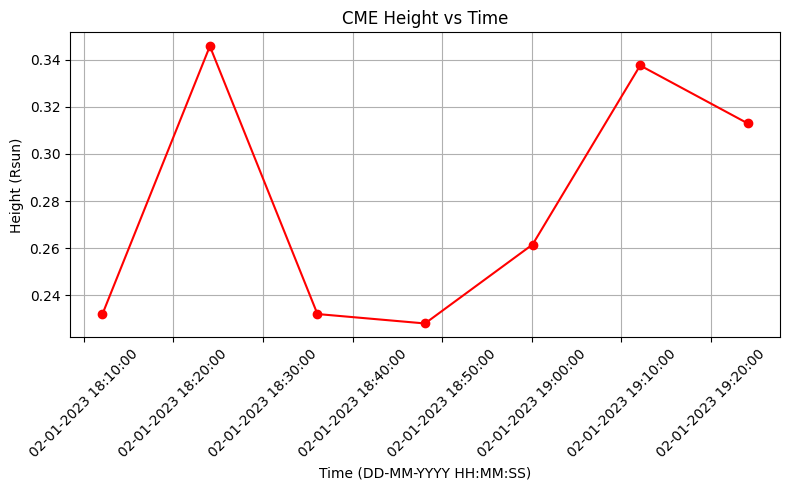

✅ Saved height-time data to /content/cme_ht.csv


In [92]:
df = process_cme_sequence("/content/lasco_data/2023-01-02T18-36_C2/", output_csv="/content/cme_ht.csv")